In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
OSCILLATOR = '153'  # 153, 154 or 155
TIME_FRAME = 'M'  # 'H', 'M' or 'S'
EXPORTED_TIMESTAMP = '1656423962'

def get_file_path(oscillator, time_frame, dataset):
    if time_frame == 'H':
        return f"./datasets/10.15.237.{oscillator}_hr_{EXPORTED_TIMESTAMP}/{dataset}.csv"
    elif time_frame == 'M':
        return f"./datasets/10.15.237.{oscillator}_min_{EXPORTED_TIMESTAMP}/{dataset}.csv"
    elif time_frame == 'S':
        return f"./datasets/10.15.237.{oscillator}_sec_{EXPORTED_TIMESTAMP}/{dataset}.csv"

Queremos conseguir los Timestamps donde el oscilador esté en estado Lock estable; es decir, que el valor de xoState sea $4$

In [3]:
def get_raw_states(oscillator, time_frame):
    states_path = get_file_path(oscillator,time_frame,'xoState')
    
    df = pd.read_csv(states_path)
    df = df.drop(['End: -1'], axis=1)
    df.columns = ['Timestamp','State']
    df = df.drop(0, axis=0)
    df['State'] = df['State'].astype(np.float64)
    
    return df

In [4]:
df = get_raw_states(OSCILLATOR,TIME_FRAME)

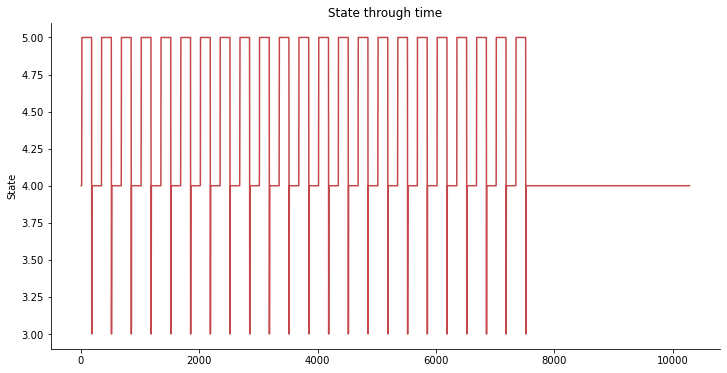

In [5]:
plt.figure(figsize=(12,6))
plt.title("State through time")
sns.set_style("darkgrid")
sns.lineplot(data=df["State"], color="#c6474b")
#plt.ylabel("State")
sns.despine()
#plt.savefig("fotos/state_through_time_constant_lock_included.png")

In [6]:
def delete_constant_lock_values(df):
    for i in range(len(df)):
        if df.iloc[len(df)-i-1]['State'] != 4.0:
            constant_lock_start = df.iloc[len(df)-i]['Timestamp']
            break
    
    df = df[:df[df['Timestamp']==constant_lock_start].index.values[0]]
    return df

In [7]:
df = delete_constant_lock_values(df)

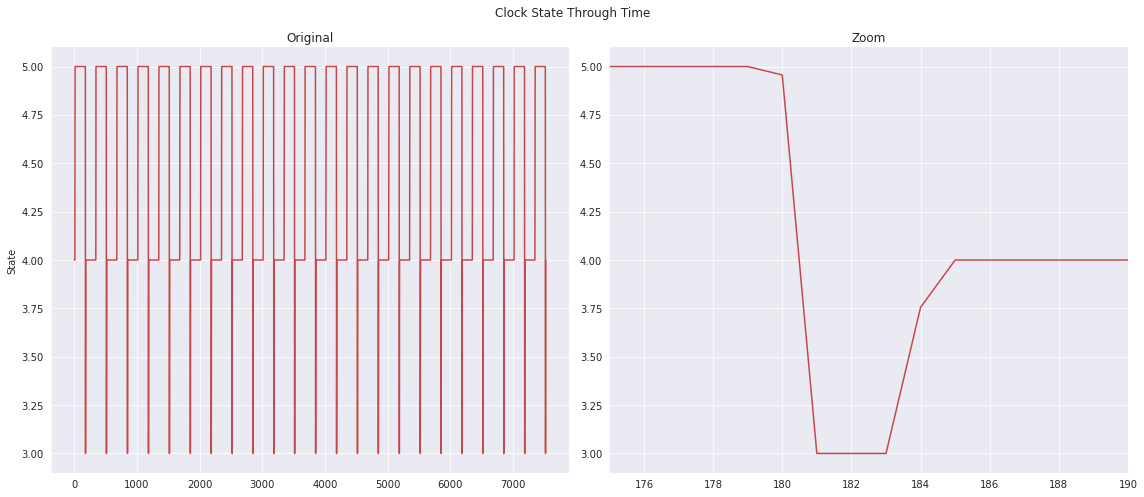

In [8]:
plt.figure(figsize=(16,7))
plt.subplot(1, 2, 1)
plt.title("Original")
sns.set_style("darkgrid")
sns.lineplot(data=df["State"], color="#c6474b")
#plt.ylabel("State")
sns.despine()

#plot 2:
plt.subplot(1, 2, 2)
plt.title("Zoom")
sns.set_style("darkgrid")
sns.lineplot(data=df["State"],color="#c6474b")
plt.ylabel("")
sns.despine()
plt.xlim([175,190])
plt.suptitle("Clock State Through Time")
plt.tight_layout()
#plt.savefig("fotos/state_through_time.png")

In [9]:
len(df)

7518

In [10]:
def get_lock_state_timestamps(raw_df):
    df = raw_df.loc[raw_df["State"]==4]
    df = df.drop("State",axis=1)
    
    return df

In [11]:
df = get_lock_state_timestamps(df)

In [12]:
len(df)

3584

In [13]:
def join_features(df, oscillator, time_frame):
    xoDAC = get_file_path(oscillator,time_frame,'xoDac_xoState-Lock')

    dac_df = pd.read_csv(xoDAC)
    dac_df = dac_df.drop(['Start: 0','End: -1'], axis=1)
    dac_df.columns = ['Timestamp','DAC']
    dac_df = dac_df.drop(0, axis=0)
    df = df.merge(dac_df,on='Timestamp')
    
    
    xoPhaseError = get_file_path(oscillator,time_frame,'xoPhaseError_xoState-Lock')
    
    phase_df = pd.read_csv(xoPhaseError)
    phase_df = phase_df.drop(['Start: 0','End: -1'], axis=1)
    phase_df.columns = ['Timestamp','Phase Error']
    phase_df = phase_df.drop(0, axis=0)
    df = df.merge(phase_df,on='Timestamp') 
    
    
    sysOscTemp = get_file_path(oscillator,time_frame,'sysOscTemp')
    
    temp_df = pd.read_csv(sysOscTemp)
    temp_df = temp_df.drop('End: -1', axis=1)
    temp_df.columns = ['Timestamp','Temperature']
    temp_df = temp_df.drop(0, axis=0)
    df = df.merge(temp_df,on='Timestamp')
    
    
    xoFreqError = get_file_path(oscillator,time_frame,'xoFreqError_xoState-Lock')
    
    freq_df = pd.read_csv(xoFreqError)
    freq_df = freq_df.drop(['Start: 0','End: -1'], axis=1)
    freq_df.columns = ['Timestamp','Frequency Error']
    freq_df = freq_df.drop(0, axis=0)
    df = df.merge(freq_df,on='Timestamp')
    
    return df

In [14]:
def format_features(df):
    df[['DAC','Phase Error','Temperature','Frequency Error']] = df[['DAC','Phase Error','Temperature','Frequency Error']].astype(np.float64)
    df['Timestamp'] = df['Timestamp'].astype(int)
    return df

In [15]:
df = join_features(df, OSCILLATOR, TIME_FRAME)
df = format_features(df)

In [16]:
print('Number of missing values:')
print(df.isna().sum())

Number of missing values:
Timestamp          0
DAC                0
Phase Error        0
Temperature        0
Frequency Error    0
dtype: int64


In [17]:
df.head()

,Timestamp,DAC,Phase Error,Temperature,Frequency Error
0,1655806396,32391.0,30.000000,33.212209,0.000038
1,1655806456,32391.0,31.955556,33.216667,0.000038
2,1655806516,32391.0,34.000000,33.157738,0.000038
3,1655806576,32391.0,34.760870,33.184783,0.000038
4,1655806636,32391.0,35.000000,33.163043,0.000038


In [18]:
df.to_csv("datasets/processed_data.csv", index=False)

(0.0, 3584.0)

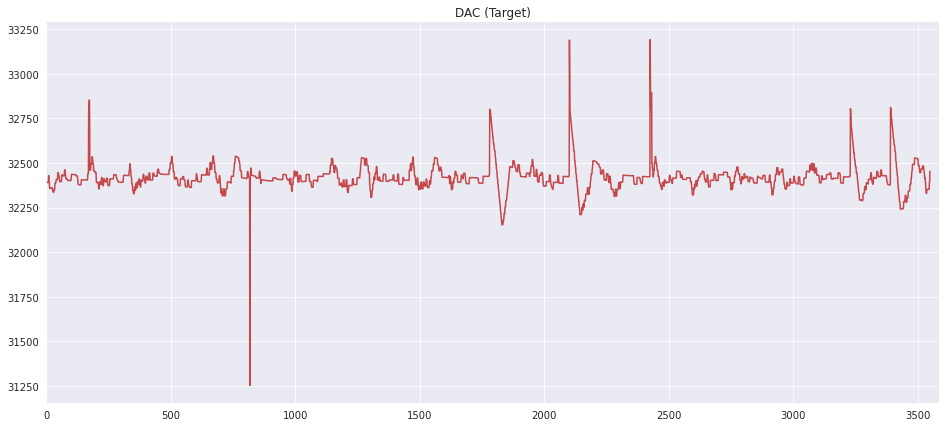

In [19]:
plt.figure(figsize=(16,7))
#plt.subplot(1, 2, 1)
plt.title("DAC (Target)")
sns.set_style("darkgrid")
sns.lineplot(data=df["DAC"].values, color="#c6474b")
#plt.ylabel("State")
sns.despine()
plt.xlim([0,3584])

#plt.savefig("fotos/raw_DAC_value_to_predict.png")

## Split DAC data into stages

In [20]:
def get_state_change_by_timestamp(oscillator, time_frame):
    state_info = get_file_path(oscillator,time_frame,'xoState_change-true')
    aux_df = pd.read_csv(state_info)
    aux_df = aux_df.drop(['Start: 0','End: -1'], axis=1)
    aux_df.columns = ['Timestamp','Lock=4']
    aux_df = aux_df.drop(0, axis=0)
    aux_df['Lock=4'] = aux_df['Lock=4'].astype(np.float64)
    
    return aux_df

In [21]:
state_info = get_state_change_by_timestamp(OSCILLATOR, TIME_FRAME)

In [22]:
state_info.head(10)

,Timestamp,Lock=4
1,1655807116,5.0
2,1655817206,3.0
3,1655817387,4.0
4,1655827178,5.0
5,1655837209,3.0
6,1655837389,4.0
7,1655847299,5.0
8,1655857330,3.0
9,1655857510,4.0
10,1655867419,5.0


In [23]:
state_info['Lock=4'].value_counts()

4.0    24
3.0    23
5.0    23
Name: Lock=4, dtype: int64

In [24]:
stages = np.array([])
new_stage = np.array([])
start_stage = False
init_timestamp = int(0)
count = 0
for index,row in state_info.iterrows():
    if start_stage == True:
        for i,r in df.iterrows():
            if int(r['Timestamp']) >= init_timestamp and int(r['Timestamp']) <= int(row['Timestamp']):
                new_stage = np.append(new_stage,r['DAC'])
                #print(new_stage)
                
        stages = np.append(stages,[count,new_stage])
        count += 1
        #print(stages)
        new_stage = np.array([])
        start_stage = False
    if row['Lock=4']==4:
        init_timestamp = int(row['Timestamp'])
        start_stage=True

/home/dcardenas11/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [25]:
for i in range(int(len(stages)/2)):
    print(stages[2*i+1].shape[0])

159
162
161
162
162
160
161
160
159
162
161
161
159
161
163
162
159
1
161
161
161
161
158


In [26]:
print(stages[34])

17


In [27]:
stages = np.delete(stages,34)
stages = np.delete(stages,34)

In [28]:
suma=0
for i in range(int(len(stages)/2)):
    print(stages[2*i+1].shape[0])
    suma+=int(stages[2*i+1].shape[0])

159
162
161
162
162
160
161
160
159
162
161
161
159
161
163
162
159
161
161
161
161
158


In [29]:
print(suma)

3536


In [30]:
stages = stages.reshape(int(len(stages)/2),2)

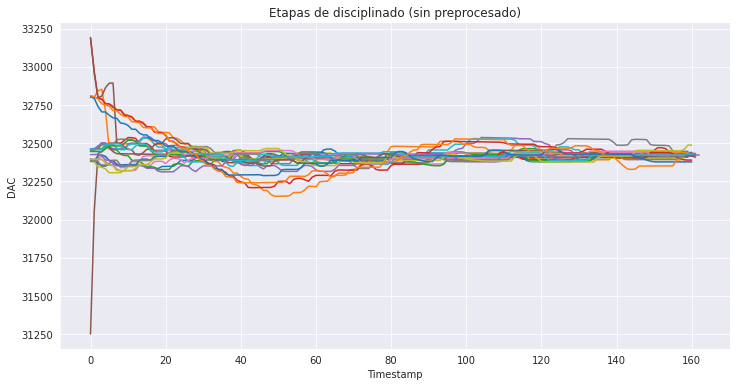

In [31]:
plt.figure(figsize=(12,6))
plt.title('Etapas de disciplinado (sin preprocesado)')
for stage in stages:
    sns.lineplot(data=stage[1])

sns.set_style("darkgrid")
plt.xlabel('Timestamp')
plt.ylabel('DAC')
sns.despine()

plt.savefig('./fotos/etapas_sin_preprocesado.png')

In [32]:
m=150
for stage in stages:
    if len(stage[1]) < m:
        m=len(stage[1])

for stage in stages:
    while len(stage[1]) > m:
        stage[1] = np.delete(stage[1],0)

In [33]:
for i in range(int(len(stages))):
    print(stages[i][1].shape[0])

150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150
150


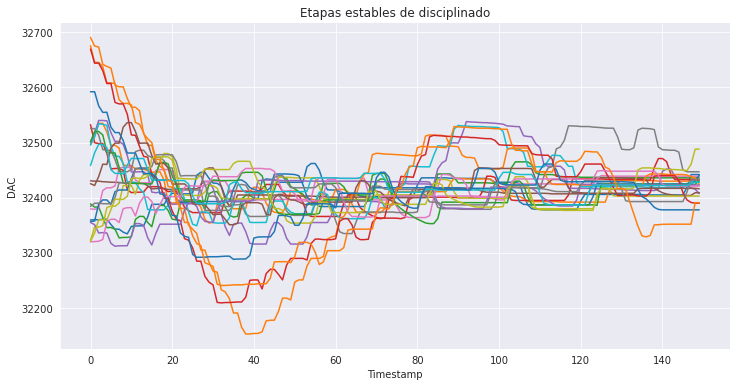

In [34]:
plt.figure(figsize=(12,6))
plt.title('Etapas estables de disciplinado')
for stage in stages:
    sns.lineplot(data=stage[1])

sns.set_style("darkgrid")
plt.xlabel('Timestamp')
plt.ylabel('DAC')
sns.despine()

plt.savefig('./fotos/etapas_estables.png')

In [35]:
st = np.array([])
for stage in stages:
    st = np.append(st,stage[1])

### Join Features according to stages

In [36]:
len(df)

3549

In [37]:
def filter_stages_by_n_initial_values(df, state_info, N):   
    data = []
    new_stage = []
    start_stage = False
    init_timestamp = int(0)
    for index,row in state_info.iterrows():
        if start_stage == True:
            for i,r in df.iterrows():
                if int(r['Timestamp']) >= init_timestamp and int(r['Timestamp']) <= int(row['Timestamp']):
                    data.append(r)
            start_stage = False
        if row['Lock=4']==4:
            init_timestamp = int(row['Timestamp'])
            start_stage=True
    
    df = pd.DataFrame(data, columns=df.columns)
    df = df.reset_index()
    df = df.drop('index',axis=1)
    df = format_features(df)
    
    times = df['Timestamp'].values
    new_stage = []
    prev = times[0]
    count = N
    stages = 0

    for time in times[1:]:
        if count > 0:
            new_stage.append(1.0)
            count -= 1
            prev = time
        else:
            new_stage.append(0.0)
            if time > prev+300:
                count = N
            prev = time
            
    df['New Stage'] = pd.Series(new_stage)
    df = df[df['New Stage']==0.0]    # Deleting first N values of each stage
    df = df.drop("New Stage",axis=1)
    return df

In [38]:
df = filter_stages_by_n_initial_values(df, state_info, 10)

In [39]:
len(df)

3316

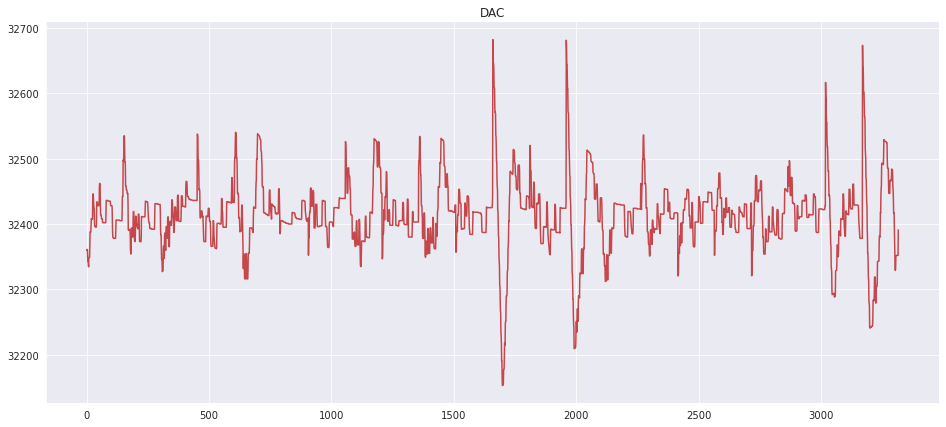

In [40]:
plt.figure(figsize=(16,7))
#plt.subplot(1, 2, 1)
plt.title("DAC")
sns.set_style("darkgrid")
sns.lineplot(data=df["DAC"].values, color="#c6474b")
#plt.ylabel("State")
sns.despine()
#plt.xlim([0,3584])
plt.savefig('./fotos/DAC_n_valores_fuera.png')

In [41]:
df.to_csv("datasets/processed_data_with_stages.csv", index=False)